In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/test-monkey/monkey_2.jpg
/kaggle/input/test-monkey/monkey_1.jpg
/kaggle/input/monkey-breed-dataset/monkey_labels.txt
/kaggle/input/monkey-breed-dataset/validation/validation/n4/n404.jpg
/kaggle/input/monkey-breed-dataset/validation/validation/n4/n402.jpg
/kaggle/input/monkey-breed-dataset/validation/validation/n4/n4010.jpg
/kaggle/input/monkey-breed-dataset/validation/validation/n4/n406.jpg
/kaggle/input/monkey-breed-dataset/validation/validation/n4/n416.jpg
/kaggle/input/monkey-breed-dataset/validation/validation/n4/n4013.jpg
/kaggle/input/monkey-breed-dataset/validation/validation/n4/n417.jpg
/kaggle/input/monkey-breed-dataset/validation/validation/n4/n409.jpg
/kaggle/input/monkey-breed-dataset/validation/validation/n4/n414.jpg
/kaggle/input/monkey-breed-dataset/validation/validation/n4/n411.jpg
/kaggle/input/monkey-breed-dataset/validation/validation/n4/n4011.jpg
/kaggle/input/monkey-breed-dataset/validation/validation/n4/n407.jpg
/kaggle/input/monkey-breed-dataset/val

In [2]:
from keras.applications import MobileNet
from keras.models import Sequential,Model 
from keras.layers import Dense,Dropout,Activation,Flatten,GlobalAveragePooling2D
from keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
train_data_dir = '../input/monkey-breed-dataset/training/training/'
validation_data_dir = '../input/monkey-breed-dataset/validation/validation/'

img_rows,img_cols = 224,224

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    width_shift_range=0.3,
                    height_shift_range=0.3,
                    horizontal_flip=True,
                    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size = (img_rows,img_cols),
                        batch_size = batch_size,
                        class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
                            validation_data_dir,
                            target_size=(img_rows,img_cols),
                            batch_size=batch_size,
                            class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [4]:
# MobileNet is designed to work with images of dim 224,224
MobileNet = MobileNet(weights='imagenet',include_top=False,input_shape=(img_rows,img_cols,3))

17227776/17225924 [==============================] - 0s 0us/step


In [5]:
# Here we freeze the last 4 layers
# Layers are set to trainable as True by default

for layer in MobileNet.layers:
    layer.trainable = False

In [6]:
# Let's print our layers
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i),layer.__class__.__name__,layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False
45 BatchNormalization False
46 ReLU False
47 Conv2D False
48 Batc

In [7]:
def addTopModelMobileNet(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    
    top_model = Dense(1024,activation='relu')(top_model)
    
    top_model = Dense(512,activation='relu')(top_model)
    
    top_model = Dense(num_classes,activation='softmax')(top_model)

    return top_model

In [8]:
num_classes = 10 

FC_Head = addTopModelMobileNet(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [9]:

from keras.optimizers import RMSprop,Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint = ModelCheckpoint(
                             'monkey_breed_mobilNet.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(
                          monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

callbacks = [earlystop,checkpoint,learning_rate_reduction]

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [11]:
nb_train_samples = 1097
nb_validation_samples = 272  

epochs = 25
batch_size = 32

history = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples//batch_size,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples//batch_size)

Epoch 1/25
34/34 [==============================] - 47s 1s/step - loss: 1.3560 - accuracy: 0.5704 - val_loss: 0.4105 - val_accuracy: 0.8242

Epoch 00001: val_loss improved from inf to 0.41049, saving model to monkey_breed_mobilNet.h5
Epoch 2/25
34/34 [==============================] - 41s 1s/step - loss: 0.4617 - accuracy: 0.8462 - val_loss: 0.2772 - val_accuracy: 0.9250

Epoch 00002: val_loss improved from 0.41049 to 0.27722, saving model to monkey_breed_mobilNet.h5
Epoch 3/25
34/34 [==============================] - 41s 1s/step - loss: 0.3631 - accuracy: 0.8851 - val_loss: 0.1070 - val_accuracy: 0.9500

Epoch 00003: val_loss improved from 0.27722 to 0.10704, saving model to monkey_breed_mobilNet.h5
Epoch 4/25
34/34 [==============================] - 41s 1s/step - loss: 0.3082 - accuracy: 0.8918 - val_loss: 0.0749 - val_accuracy: 0.9375

Epoch 00004: val_loss improved from 0.10704 to 0.07491, saving model to monkey_breed_mobilNet.h5
Epoch 5/25
34/34 [==============================] - 

It is a : silvery_marmoset


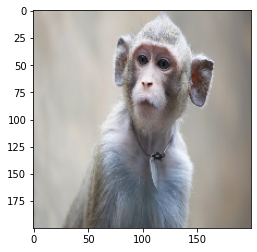

In [12]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np 
from skimage import io
import matplotlib.pyplot as plt

classifier = load_model('/kaggle/working/monkey_breed_mobilNet.h5')
class_labels = ['mantled_howler', 
                'patas_monkey', 
                'bald_uakari', 
                'japanese_macaque', 
                'pygmy_marmoset', 
                'white_headed_capuchin',
                'silvery_marmoset',
                'common_squirrel_monkey', 
                'black_headed_night_monkey',
                'nilgiri_langur' ]

from skimage import io
img = image.load_img('../input/test-monkey/monkey_1.jpg', color_mode = "rgb", target_size=(224, 224))
show_img=image.load_img('../input/test-monkey/monkey_1.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

pred = classifier.predict(x)[0]
label = class_labels[pred.argmax()]

plt.imshow(show_img)
print('It is a :',label)
